Test GN model-enhanced GPs for robustness to extreme points. 
Perturb a given SNR value and observe the difference between the physical model-enhanced GP and the normal GP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [80]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

Play around with the amount of data

In [81]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

In [82]:
len(pch)

23

Add a large perturbation to one of the points to see if the physical model-enhanced GP is more robust to it.

In [83]:
#np.random.seed()
per_ind = 7 #np.random.randint(0, len(snr))
snr[per_ind] = snr[per_ind] - 0.5

Use all data for fitting.

In [84]:
snr_fit = snr[:].reshape(-1,1)
pch_fit = pch[:].reshape(-1,1)

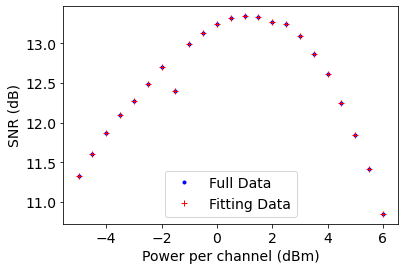

In [85]:
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_fit, snr_fit, 'r+', label='Fitting Data')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [86]:
phys_model = GN_model(100, 1550, 1, 1.1, 18, 0.18, 35, 40.2, 50, 4, 10)

According to Javier, the measurements of Pch may not be reliable and we may need to shift them in order to obtain agreement with the GN model. We do this by calculating the input power per channel that corresponds to peak SNR in the GN model and shifting the peak of measured data to line up with this prediction.

In [87]:
pch_gn = np.linspace(-5, 5, 100)
pch_fit_shifted = pch_fit - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
pch_shifted = pch - (1.25 - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
snr_phys = phys_model.predict_snr(pch_fit_shifted).reshape(-1,1)

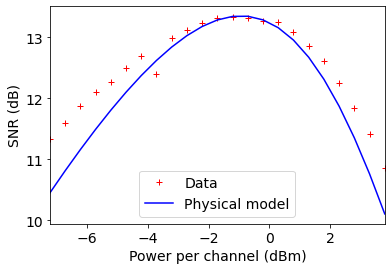

In [88]:
plt.plot(pch_fit_shifted, snr_fit, 'r+', label='Data')
plt.plot(pch_fit_shifted, snr_phys, 'b-', label='Physical model')
plt.xlim([pch_fit_shifted[0], pch_fit_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

Need to think about how many datapoints I will use for the physical model - ideally dont want to use the same number of datapoints as the data as then we dont get the benefit for a low number of points... 

In [89]:
num_points_phys = 20
#pch_test = np.linspace(pch_fit_shifted[0], pch_fit_shifted[-1], 50).reshape(-1,1) 
pch_test = np.linspace(pch_shifted[0], pch_shifted[-1], num_points_phys).reshape(-1,1) 
#snr_phys_test = phys_model.predict_snr(pch_test).reshape(-1,1)
snr_phys_test = (phys_model.predict_snr(pch_test).reshape(len(pch_test),) + np.random.normal(0, 0.03, len(pch_test))).reshape(-1,1)

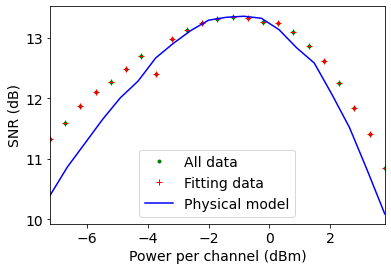

In [90]:
#plt.plot(pch_shifted[-9:], snr[-9:], 'g.', label='All data')
plt.plot(pch_shifted, snr, 'g.', label='All data')
plt.plot(pch_fit_shifted, snr_fit, 'r+', label='Fitting data')
plt.plot(pch_test, snr_phys_test, 'b-', label='Physical model')
plt.xlim([pch_shifted[0], pch_shifted[-1]])
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
#plt.savefig('powershifted_gn_comparison.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [91]:
pch_fit_shifted = pch_fit_shifted.reshape(-1, 1)  # needed for SK learn input
#pch_predict = np.linspace(pch_shifted[0], pch_shifted[-1] + 1.0)
pch_shifted = pch_shifted.reshape(-1,1)
kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr_phys.fit_phys(pch_fit_shifted, pch_test, snr_fit, snr_phys_test)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk_phys, std_sk_phys = gpr_phys.predict(pch_shifted, return_std=True)
std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
theta_phys = gpr_phys.kernel_.theta
lml_phys = gpr_phys.log_marginal_likelihood()
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

In [92]:
pch_fit_shifted = pch_fit_shifted.reshape(-1, 1)  # needed for SK learn input
pch_shifted = pch_shifted.reshape(-1, 1)  # needed for SK learn input
kernel_sk =   C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) + W(1, (1e-5,1e5))
gpr = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
gpr.fit(pch_fit_shifted, snr_fit)
#print("Optimised kernel: %s" % gpr.kernel_)
mu_sk, std_sk = gpr.predict(pch_shifted, return_std=True)
std_sk = np.reshape(std_sk,(np.size(std_sk), 1)) 
theta = gpr.kernel_.theta
lml = gpr.log_marginal_likelihood()
mu_sk_p2 = mu_sk + 2*std_sk 
mu_sk_n2 = mu_sk - 2*std_sk 

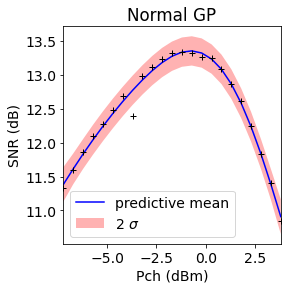

In [93]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2,
                            (mu_sk_n2)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Normal GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('normal_GP.pdf', dpi=200,bbox_inches='tight')
plt.show()

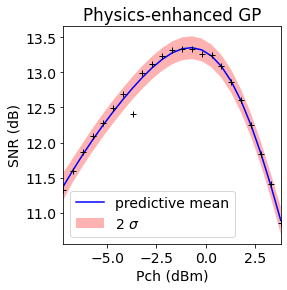

In [94]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk_phys, 'b-', label = 'predictive mean')
ax.plot(pch_shifted, snr,'k+')
#ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2 $\sigma$')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Physics-enhanced GP")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
f.patch.set_facecolor('w')
plt.savefig('phys_enhanced_GP.pdf', dpi=200,bbox_inches='tight')
plt.show()

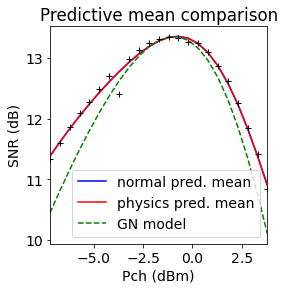

In [95]:
f, ax = plt.subplots()
ax.plot(pch_shifted, mu_sk, 'b-', label = 'normal pred. mean')
ax.plot(pch_shifted, mu_sk_phys, 'r-', label = 'physics pred. mean')
ax.plot(pch_shifted, snr_phys, 'g--', label = 'GN model')
ax.plot(pch_shifted, snr,'k+')
plt.xlim(pch_shifted[0], pch_shifted[-1])
plt.xlabel("Pch (dBm)")
plt.ylabel("SNR (dB)")
plt.title("Predictive mean comparison")
plt.legend()
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig('pred_mean_comp.pdf', dpi=200,bbox_inches='tight')
plt.show()

**Observations:**
* The physical model changes the way the GP *interprets* the perturbed point
* The standard GP increases the predictive variance to accomodate for this point, resulting in inaccurate characterisation of the noise level and a deviation of the predictive mean
* The physics-enhanced GP uses a priori knowledge of the physics of the system to identify this outlier point as an outlier - the predictive variance of the model is not increased significantly to accomodate this point
* Note that we had to add AWGN with $\sigma = 0.03$ dB to the GN model predictions in order to prevent overfitting

In [29]:
max(std_sk)

array([0.16881841])

In [31]:
max(std_sk_phys)

array([0.09902544])

Relative change in the predictive std (%):

In [32]:
100*(max(std_sk_phys) - max(std_sk))/max(std_sk)

array([-41.34203492])

Drop in predictive std due to change in interpretation of outlier point!

RMSD of the predictive mean of the model with and without physical models:

In [33]:
np.mean(((mu_sk - mu_sk_phys)**2)**0.5)

0.014609001517925298

Mean relative difference (%):

In [34]:
np.mean(100*(mu_sk - mu_sk_phys)/mu_sk)

0.02051430347209369

In [35]:
np.exp(theta)  # mu, l, sigma: kernel specified as mu**2 * RBF(l**2) + I sigma**2 

array([2.28419688, 1.91170259, 0.1348588 ])

In [36]:
np.exp(theta_phys)

array([7.43645128, 2.76016169, 0.04397225])